#IMPORT LIBRARIES

In [ ]:
!pip install numpy==1.23.5 --force-reinstall

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 re

In [ ]:
!pip install --quiet kaggle

In [ ]:
!pip install -U gdown
!gdown --id 0B7XkCwpI5KDYNlNUTTlSS21pQmM --output GoogleNews-vectors-negative300.bin.gz

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
From (redirected): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&confirm=t&uuid=b1c1a1be-a03d-4890-93eb-67a34d2f9ad8
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:10<00:00, 163MB/s]


In [ ]:
!gunzip GoogleNews-vectors-negative300.bin.gz

In [ ]:
# 1. Install the Kaggle API
!pip install --quiet kaggle

# 2. Move your key into ~/.kaggle and secure it
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# 3. Download the Quora Question Pairs data into /content
!kaggle competitions download -c quora-question-pairs -p /content

# 4. Unzip
!unzip -q /content/quora-question-pairs.zip -d /content/quora
!ls /content/quora

sample_submission.csv.zip  test.csv  test.csv.zip  train.csv.zip


In [ ]:
!unzip -q /content/quora/train.csv.zip -d /content/quora

In [ ]:
!unzip -q /content/quora/sample_submission.csv.zip -d /content/quora

In [ ]:
import pandas as pd

# adjust these paths if you used a different folder
TRAIN_PATH = "/content/quora/train.csv"
TEST_PATH  = "/content/quora/test.csv"
SUB_PATH   = "/content/quora/sample_submission.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sub   = pd.read_csv(SUB_PATH)

In [ ]:
train.shape, test.shape

((404290, 6), (2345796, 3))

In [110]:
!pip install distance
!pip install fuzzywuzzy
!pip install xgboost

In [111]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy
from fuzzywuzzy import fuzz
import distance

# Download NLTK data
nltk.download('stopwords')

# Sklearn - preprocessing, models, evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, log_loss
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# XGBoost
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:
pd.set_option('display.max_columns', None)      # Show all columns
pd.set_option('display.width', 0)               # Auto-detect width
pd.set_option('display.max_colwidth', None)     # Show full column contents

In [ ]:
df = train.copy()

#EDA

##Shape + Head

In [ ]:
df.shape

(404290, 6)

In [ ]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


##Null Value

In [ ]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [ ]:
df.dropna(inplace=True)

##Duplicate Vs Non-Duplicate

<Axes: xlabel='is_duplicate'>

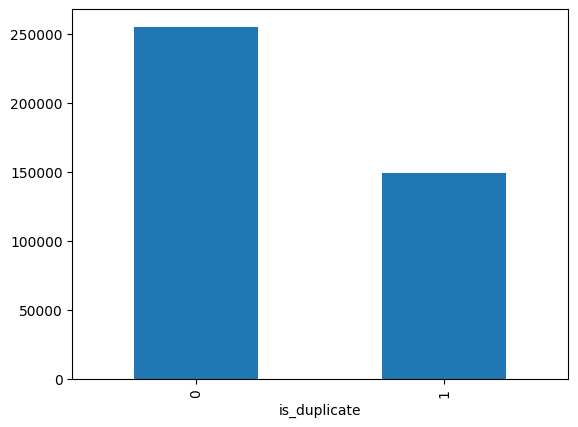

In [ ]:
df['is_duplicate'].value_counts().plot(kind='bar')

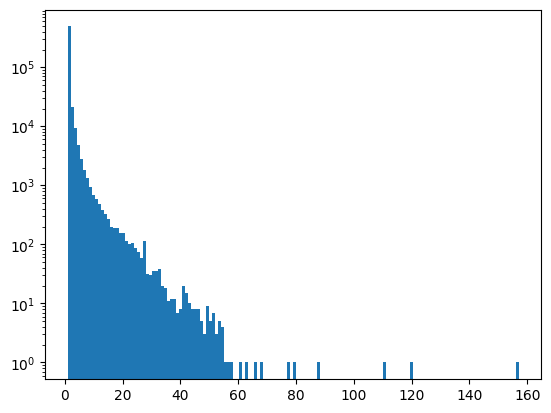

In [ ]:
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
plt.hist(qid.value_counts().values,bins=150)
plt.yscale('log')
plt.show()

#PREPROCESSING

##Steps
1.   Lower Case
2.   Remove Emoji
3.   remove html
4.   remove url
5.   Replace certain special characters with their string equivalents
6.   Replace contractions
7.   Remove *puntuations*

In [ ]:
def preprocess(text):
  #lower case
  text = str(text).lower().strip()

  #remove emoji
  if(type(text) == str):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F700-\U0001F77F"  # alchemical symbols
                                u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                u"\U00002702-\U000027B0"  # Dingbats
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

  #remove html
  pattern = re.compile('<.*?>')
  text = pattern.sub(r'', text)

  #remove url
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  result = url_pattern.sub('', text)
  text = result

  # Replace certain special characters with their string equivalents
  text = text.replace('%', ' percent')
  text = text.replace('$', ' dollar ')
  text = text.replace('₹', ' rupee ')
  text = text.replace('€', ' euro ')
  text = text.replace('@', ' at ')
  text = text.replace('[math]', '')

  #contractions
  text = text.replace("'ve", " have")
  text = text.replace("n't", " not")
  text = text.replace("'re", " are")
  text = text.replace("'ll", " will")

  contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
  text_decontracted = []
  for word in text.split():
    if word in contractions:
      word = contractions[word]
    text_decontracted.append(word)
  text = ' '.join(text_decontracted)

  #remove puntuations
  translator = str.maketrans('', '', string.punctuation)
  result = text.translate(translator)
  text = result

  return text

df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 2324math is divided by...,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


In [ ]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


#FEATURE ENGINEERING

## len

In [ ]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

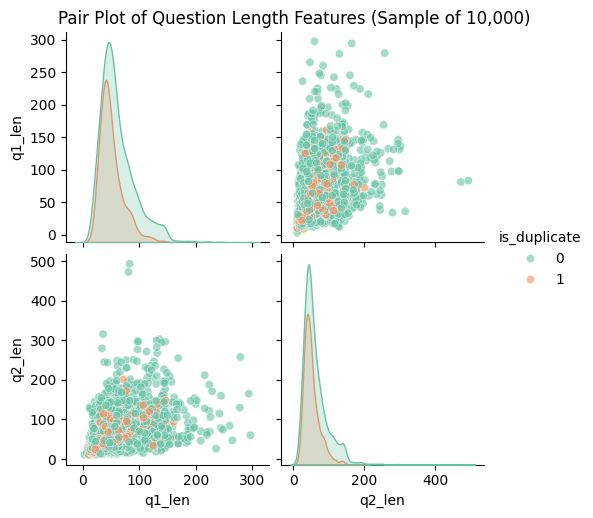

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'is_duplicate' is string
df['is_duplicate'] = df['is_duplicate'].astype(str)

# Sample 10,000 rows including required columns
sample_df = df[['q1_len', 'q2_len', 'is_duplicate']].sample(10000, random_state=42)

# Pair plot
sns.pairplot(sample_df, hue='is_duplicate', palette='Set2', plot_kws={'alpha': 0.6})
plt.suptitle("Pair Plot of Question Length Features (Sample of 10,000)", y=1.02)
plt.show()

## fetch_length_features

In [ ]:
from difflib import SequenceMatcher
import numpy as np

def fetch_length_features(row):
    q1 = str(row['question1'])
    q2 = str(row['question2'])

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if not q1_tokens or not q2_tokens:
        return [0.0]*7

    len_q1 = len(q1_tokens)
    len_q2 = len(q2_tokens)

    min_len = min(len(q1), len(q2))
    max_len = max(len(q1), len(q2))

    # SequenceMatcher is significantly faster for longest common substring
    match = SequenceMatcher(None, q1, q2).find_longest_match(0, len(q1), 0, len(q2))
    lcs_len = match.size if match.size > 0 else 0

    return [
        len_q1,
        len_q2,
        abs(len_q1 - len_q2),
        (len_q1 + len_q2) / 2.0,
        lcs_len,
        lcs_len / min_len if min_len else 0.0,
        lcs_len / max_len if max_len else 0.0
    ]

# Apply once and convert to numpy array for speed
features_array = np.array(df.apply(fetch_length_features, axis=1).tolist())

# Assign columns directly using NumPy slicing (much faster)
df[['q1_token_no', 'q2_token_no', 'abs_len_diff', 'mean_len',
    'longest_substr', 'longest_substr_ratio_min', 'longest_substr_ratio_max']] = features_array

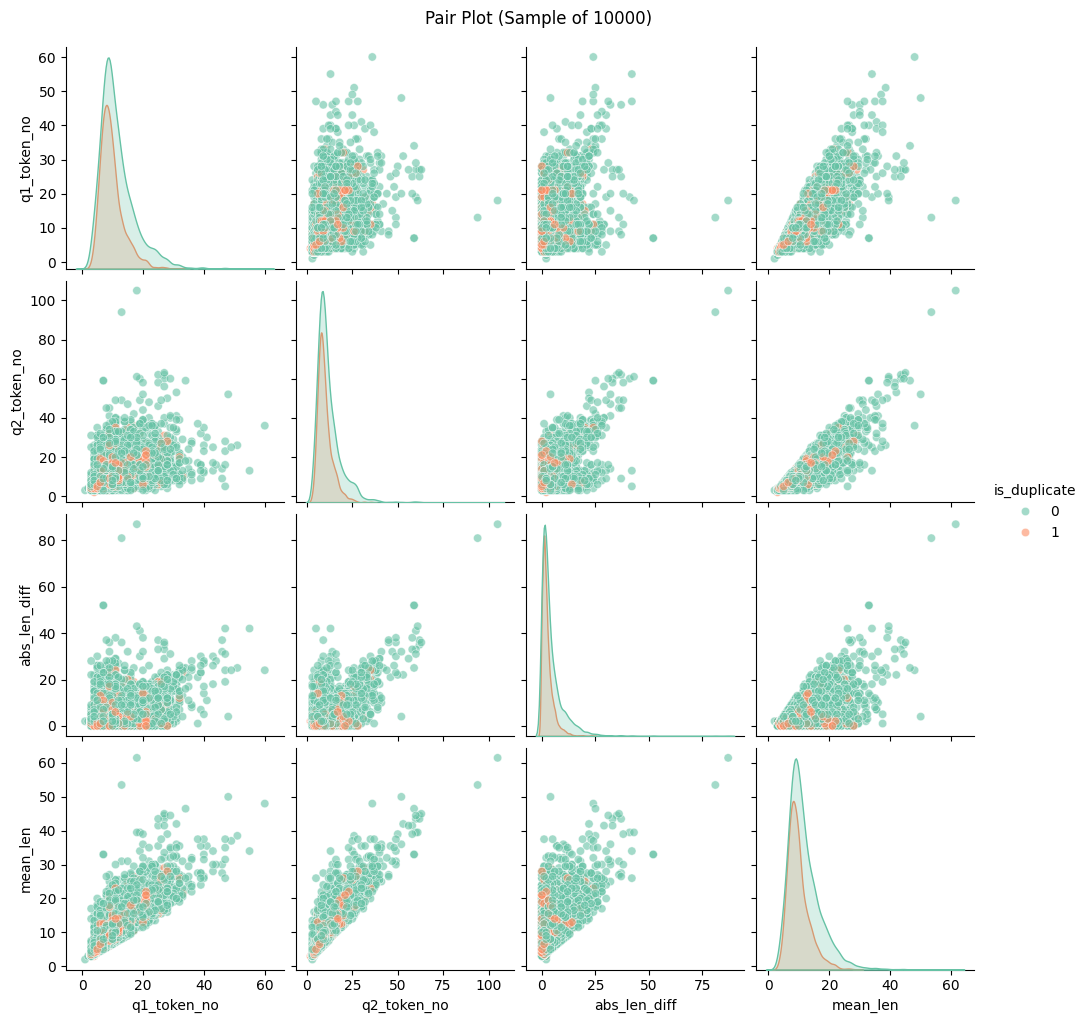

In [ ]:
df['is_duplicate'] = df['is_duplicate'].astype(str)

sample_df = df[['q1_token_no', 'q2_token_no', 'abs_len_diff', 'mean_len', 'is_duplicate']].sample(10000, random_state=42)

sns.pairplot(sample_df, hue='is_duplicate', palette='Set2', plot_kws={'alpha': 0.6})
plt.suptitle("Pair Plot (Sample of 10000)", y=1.02)
plt.show()

## fetch_token_features

In [ ]:
from nltk.corpus import stopwords
import numpy as np

STOP_WORDS = set(stopwords.words("english"))  # move this outside the function

def fetch_token_features(row):
    q1 = str(row['question1'])
    q2 = str(row['question2'])

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if not q1_tokens or not q2_tokens:
        return [0.0]*11

    q1_set = set(q1_tokens)
    q2_set = set(q2_tokens)

    q1_words = q1_set - STOP_WORDS
    q2_words = q2_set - STOP_WORDS

    q1_stops = q1_set & STOP_WORDS
    q2_stops = q2_set & STOP_WORDS

    common_words = q1_words & q2_words
    common_stops = q1_stops & q2_stops
    common_tokens = q1_set & q2_set

    len_q1 = len(q1_tokens)
    len_q2 = len(q2_tokens)
    total_words = len_q1 + len_q2

    token_features = [
        len(common_tokens),
        total_words,
        len(common_tokens) / total_words if total_words != 0 else 0.0,
        len(common_words) / (min(len(q1_words), len(q2_words)) + 1e-5),
        len(common_words) / (max(len(q1_words), len(q2_words)) + 1e-5),
        len(common_stops) / (min(len(q1_stops), len(q2_stops)) + 1e-5),
        len(common_stops) / (max(len(q1_stops), len(q2_stops)) + 1e-5),
        len(common_tokens) / (min(len_q1, len_q2) + 1e-5),
        len(common_tokens) / (max(len_q1, len_q2) + 1e-5),
        int(q1_tokens[-1] == q2_tokens[-1]),
        int(q1_tokens[0] == q2_tokens[0])
    ]

    return token_features
token_features_array = np.array(df.apply(fetch_token_features, axis=1).tolist())

df[['common_words', 'total_words', 'ratio_of_common_to_total',
    'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
    'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq']] = token_features_array

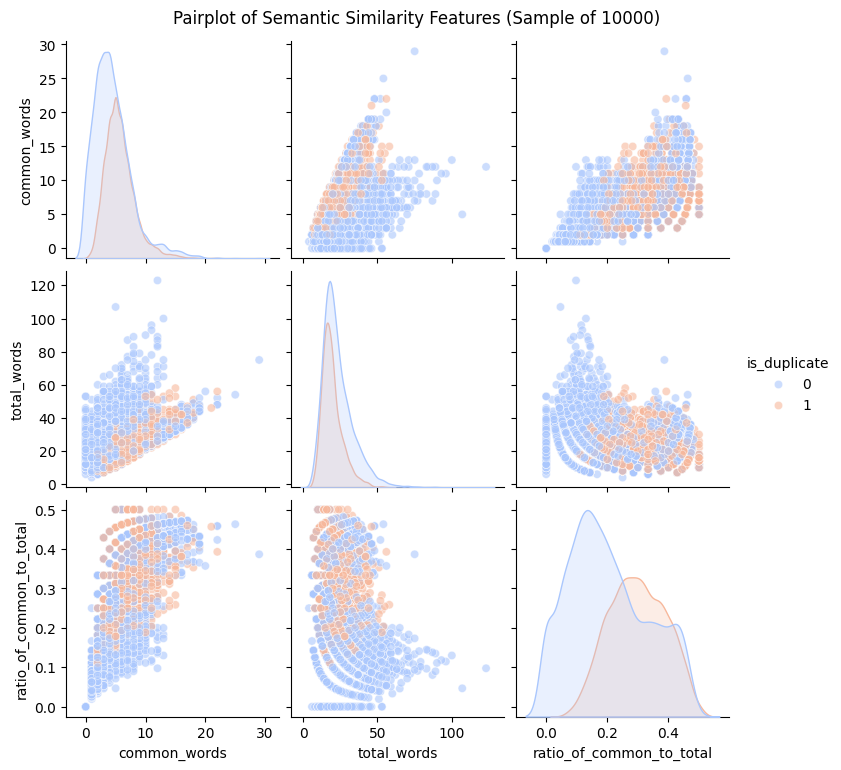

In [ ]:
# Define your selected columns
selected_cols = ["common_words", "total_words", "ratio_of_common_to_total", "is_duplicate"]

# Ensure 'is_duplicate' is string for coloring
df['is_duplicate'] = df['is_duplicate'].astype(str)

# Sample 1000 rows from the selected columns
sample_df = df[selected_cols].sample(10000, random_state=42)

# Pairplot
sns.pairplot(sample_df, hue='is_duplicate', palette='coolwarm', plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot of Semantic Similarity Features (Sample of 10000)", y=1.02)
plt.show()

## fetch_fuzzy_features

In [ ]:
from fuzzywuzzy import fuzz
import numpy as np

def fetch_fuzzy_features(row):
    q1, q2 = str(row['question1']), str(row['question2'])

    return [
        fuzz.QRatio(q1, q2),
        fuzz.partial_ratio(q1, q2),
        fuzz.token_sort_ratio(q1, q2),
        fuzz.token_set_ratio(q1, q2)
    ]
fuzzy_features_array = np.array(df.apply(fetch_fuzzy_features, axis=1).tolist())

df[['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio']] = fuzzy_features_array

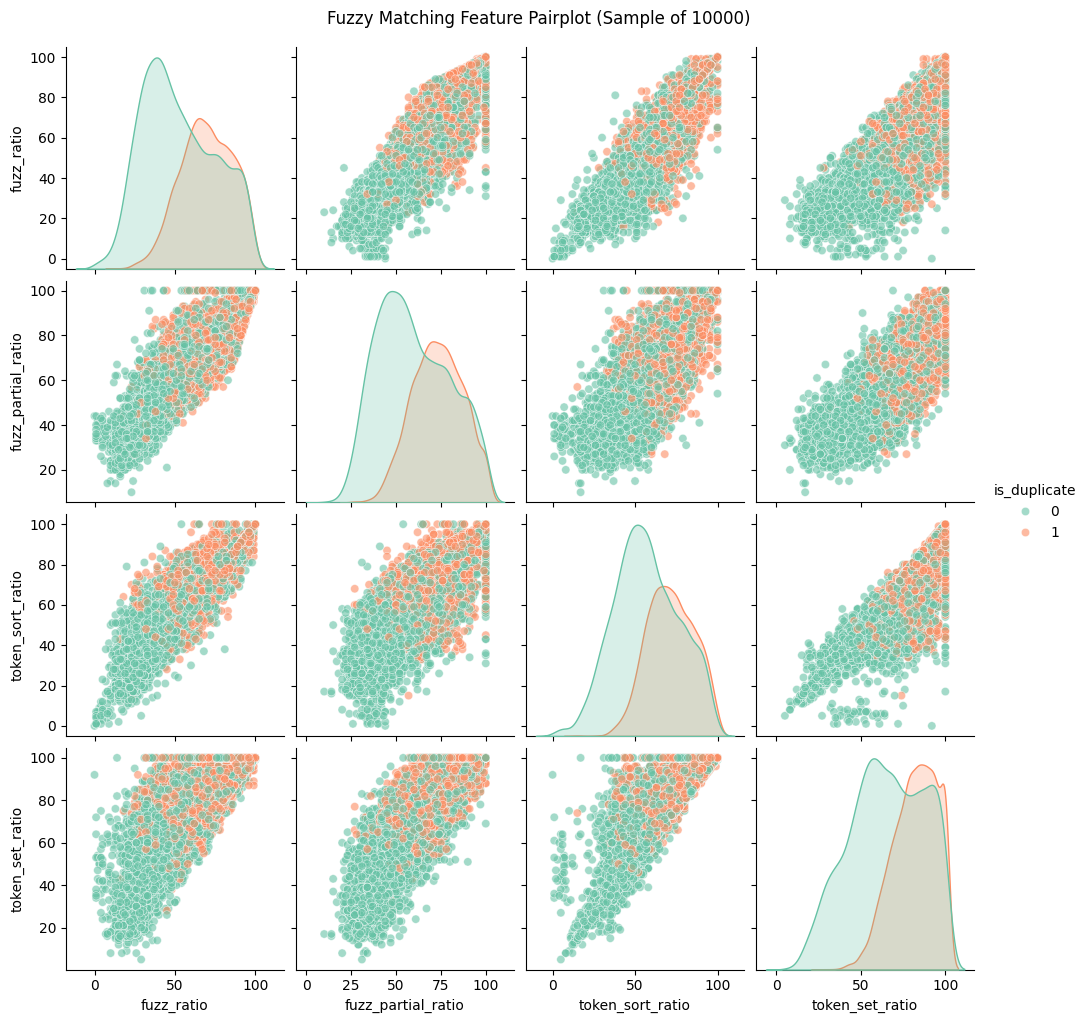

In [ ]:
# Define fuzzy feature columns
fuzzy_cols = ['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'is_duplicate']

# Sample and prepare DataFrame
plot_df = df[fuzzy_cols].sample(10000, random_state=42).copy()
plot_df['is_duplicate'] = plot_df['is_duplicate'].astype(str)

# Generate pairplot
sns.pairplot(plot_df, hue='is_duplicate', palette='Set2', plot_kws={'alpha': 0.6})
plt.suptitle("Fuzzy Matching Feature Pairplot (Sample of 10000)", y=1.02)
plt.show()


#WORD2VEC

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 56.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is 

In [ ]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
import numpy as np

def apply_word2vec(text):
    tokens = text.split()
    vectors = [word2vec_model[token] for token in tokens if token in word2vec_model.key_to_index]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

# Apply embeddings to both questions
q1_embeddings = np.stack(df['question1'].apply(apply_word2vec).values)
q2_embeddings = np.stack(df['question2'].apply(apply_word2vec).values)

# Get vector size once
vec_size = word2vec_model.vector_size

# Add embedding columns using NumPy slicing (vectorized and fast)
df[[f'question1_embedding_{i}' for i in range(vec_size)]] = q1_embeddings
df[[f'question2_embedding_{i}' for i in range(vec_size)]] = q2_embeddings

# MODELLING

In [ ]:
X = df.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'])
y = df['is_duplicate']
y = y.astype(int)

In [ ]:
# First split: 70% train, 30% temp (valid + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=0)

# Second split: 50% of temp for validation, 50% for test → 15% each
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [ ]:
import gc
gc.collect()

257

In [ ]:
# Apply StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [36]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, log_loss
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np
from itertools import product

# Define parameter grids
param_grids = {
    'RandomForest': {
        'n_estimators': [200, ],
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [10],
        'min_samples_leaf': [4],
        'bootstrap': [True, False]
    },
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],
        'solver': ['liblinear']
    },
    'LinearSVC': {
        'C': [0.1, 1.0, 10.0],
        'max_iter': [1000]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'max_depth': [6, 10, 15],
        'learning_rate': [0.1],
        'subsample': [0.8]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1],
        'max_depth': [4, 6]
    },
    'AdaBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [.1, 0.5]
    },
    'ExtraTrees': {
        'n_estimators': [30, 50],
        'max_depth': [10, 15]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 150],
        'num_leaves': [31, 50],
        'learning_rate': [0.1]
    },
    'NaiveBayes': {}
}

# Initialize classifiers
classifiers = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0),
    'LogisticRegression': LogisticRegression(random_state=0),
    'LinearSVC': LinearSVC(random_state=0),
    'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=0),
    'GradientBoosting': GradientBoostingClassifier(random_state=0),
    'AdaBoost': AdaBoostClassifier(random_state=0),
    'ExtraTrees': ExtraTreesClassifier(random_state=0),
    'LightGBM': LGBMClassifier(random_state=0),
    'NaiveBayes': GaussianNB()
}

# Generate parameter combinations
def generate_combinations(param_grid):
    if not param_grid:
        return [{}]
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    return [dict(zip(keys, v)) for v in product(*values)]

# Train and evaluate using different metrics
def train_and_evaluate(clf_name, clf, param_combinations, X_train, y_train, X_valid, y_valid, X_test, y_test):
    best_metrics = {
        'accuracy': {'score': -np.inf, 'params': None, 'model': None},
        'f1': {'score': -np.inf, 'params': None, 'model': None},
        'precision': {'score': -np.inf, 'params': None, 'model': None},
        'recall': {'score': -np.inf, 'params': None, 'model': None},
        'log_loss': {'score': np.inf, 'params': None, 'model': None}
    }

    for i, params in enumerate(param_combinations):
        print(f"[{clf_name}] Trying combination {i + 1}/{len(param_combinations)}: {params}")
        clf.set_params(**params)
        try:
            clf.fit(X_train, y_train)
        except Exception as e:
            print(f"Error training {clf_name} with params {params}: {e}")
            continue

        y_pred_valid = clf.predict(X_valid)
        y_pred_proba_valid = clf.predict_proba(X_valid) if hasattr(clf, 'predict_proba') else None

        current_accuracy = accuracy_score(y_valid, y_pred_valid)
        current_f1 = f1_score(y_valid, y_pred_valid, average='macro')
        current_precision = precision_score(y_valid, y_pred_valid, average='macro', zero_division=0)
        current_recall = recall_score(y_valid, y_pred_valid, average='macro', zero_division=0)
        current_log_loss = log_loss(y_valid, y_pred_proba_valid) if y_pred_proba_valid is not None else np.inf

        print(f"Validation Accuracy: {current_accuracy:.4f} | F1: {current_f1:.4f} | Precision: {current_precision:.4f} | Recall: {current_recall:.4f} | Log Loss: {current_log_loss:.4f}")

        if current_accuracy > best_metrics['accuracy']['score']:
            best_metrics['accuracy'] = {'score': current_accuracy, 'params': params, 'model': clf}
        if current_f1 > best_metrics['f1']['score']:
            best_metrics['f1'] = {'score': current_f1, 'params': params, 'model': clf}
        if current_precision > best_metrics['precision']['score']:
            best_metrics['precision'] = {'score': current_precision, 'params': params, 'model': clf}
        if current_recall > best_metrics['recall']['score']:
            best_metrics['recall'] = {'score': current_recall, 'params': params, 'model': clf}
        if current_log_loss < best_metrics['log_loss']['score']:
            best_metrics['log_loss'] = {'score': current_log_loss, 'params': params, 'model': clf}

    best_results = {}
    for metric, best in best_metrics.items():
        if best['model'] is not None:
            y_pred_test = best['model'].predict(X_test)
            y_pred_proba_test = best['model'].predict_proba(X_test) if hasattr(best['model'], 'predict_proba') else None
            test_accuracy = accuracy_score(y_test, y_pred_test)
            test_f1 = f1_score(y_test, y_pred_test, average='macro')
            test_precision = precision_score(y_test, y_pred_test, average='macro', zero_division=0)
            test_recall = recall_score(y_test, y_pred_test, average='macro', zero_division=0)
            test_log_loss = log_loss(y_test, y_pred_proba_test) if y_pred_proba_test is not None else np.inf

            best_results[metric] = {
                'Best Params': best['params'],
                'Test Accuracy': test_accuracy,
                'Test F1 Score': test_f1,
                'Test Precision': test_precision,
                'Test Recall': test_recall,
                'Test Log Loss': test_log_loss
            }

    return best_results

# Run training
results = {}
for clf_name in classifiers:
    print(f"\n=== Training {clf_name} ===")
    clf = classifiers[clf_name]
    param_combinations = generate_combinations(param_grids[clf_name])
    best_results = train_and_evaluate(
        clf_name, clf, param_combinations, X_train, y_train, X_valid, y_valid, X_test, y_test
    )
    results[clf_name] = best_results


=== Training XGBoost ===
[XGBoost] Trying combination 1/6: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8}
Validation Accuracy: 0.7852 | F1: 0.7714 | Precision: 0.7693 | Recall: 0.7739 | Log Loss: 0.4283
[XGBoost] Trying combination 2/6: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 0.8}
Validation Accuracy: 0.8110 | F1: 0.7982 | Precision: 0.7967 | Recall: 0.8000 | Log Loss: 0.3883
[XGBoost] Trying combination 3/6: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}
Validation Accuracy: 0.8274 | F1: 0.8150 | Precision: 0.8144 | Recall: 0.8156 | Log Loss: 0.3609
[XGBoost] Trying combination 4/6: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8}
Validation Accuracy: 0.8016 | F1: 0.7881 | Precision: 0.7867 | Recall: 0.7897 | Log Loss: 0.4018
[XGBoost] Trying combination 5/6: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 0.8}
Validation Accuracy: 0.828

In [38]:
# Print final results
print("\nFinal Results for all classifiers:")
for clf_name, result in results.items():
    print(f"\n{clf_name}:")
    for metric, result_data in result.items():
        print(f"\n{metric.capitalize()}:")
        for key, value in result_data.items():
            print(f"{key}: {value}")


Final Results for all classifiers:

XGBoost:

Accuracy:
Best Params: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}
Test Accuracy: 0.8370654969988787
Test F1 Score: 0.8246164956095436
Test Precision: 0.824792373988277
Test Recall: 0.8244423742250695
Test Log Loss: 0.34157922514182854

F1:
Best Params: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}
Test Accuracy: 0.8370654969988787
Test F1 Score: 0.8246164956095436
Test Precision: 0.824792373988277
Test Recall: 0.8244423742250695
Test Log Loss: 0.34157922514182854

Precision:
Best Params: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}
Test Accuracy: 0.8370654969988787
Test F1 Score: 0.8246164956095436
Test Precision: 0.824792373988277
Test Recall: 0.8244423742250695
Test Log Loss: 0.34157922514182854

Recall:
Best Params: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}
Test Accuracy: 0.8370654969988787
Test F1 

In [93]:
# Flatten the nested dictionary `results` into a list of rows
rows = []
for clf_name, metrics in results.items():
    for metric_name, metric_values in metrics.items():
        row = {
            'Classifier': clf_name,
            'Metric Optimized': metric_name
        }
        row.update(metric_values)
        rows.append(row)

# Create a DataFrame from the rows
df_results = pd.DataFrame(rows)

# Optional: Reorder columns if needed
ordered_cols = ['Classifier', 'Metric Optimized', 'Best Params',
                'Test Accuracy', 'Test F1 Score', 'Test Precision',
                'Test Recall', 'Test Log Loss']
df_results = df_results[ordered_cols]

# Display the final DataFrame
print("\nFinal Evaluation Results (as DataFrame):")
df_results


Final Evaluation Results (as DataFrame):


,Classifier,Metric Optimized,Best Params,Test Accuracy,Test F1 Score,Test Precision,Test Recall,Test Log Loss
0,XGBoost,accuracy,"{'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}",0.837065,0.824616,0.824792,0.824442,0.341579
1,XGBoost,f1,"{'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}",0.837065,0.824616,0.824792,0.824442,0.341579
2,XGBoost,precision,"{'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}",0.837065,0.824616,0.824792,0.824442,0.341579
3,XGBoost,recall,"{'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}",0.837065,0.824616,0.824792,0.824442,0.341579
4,XGBoost,log_loss,"{'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}",0.837065,0.824616,0.824792,0.824442,0.341579
5,LogisticRegression,accuracy,"{'C': 10.0, 'solver': 'liblinear'}",0.752655,0.729537,0.734141,0.726223,0.472916
6,LogisticRegression,f1,"{'C': 10.0, 'solver': 'liblinear'}",0.752655,0.729537,0.734141,0.726223,0.472916
7,LogisticRegression,precision,"{'C': 10.0, 'solver': 'liblinear'}",0.752655,0.729537,0.734141,0.726223,0.472916
8,LogisticRegression,recall,"{'C': 10.0, 'solver': 'liblinear'}",0.752655,0.729537,0.734141,0.726223,0.472916
9,LogisticRegression,log_loss,"{'C': 1.0, 'solver': 'liblinear'}",0.752655,0.729537,0.734141,0.726223,0.472916


In [105]:
print(df_results.to_markdown())

|    | Classifier         | Metric Optimized   | Best Params                                                                                                |   Test Accuracy |   Test F1 Score |   Test Precision |   Test Recall |   Test Log Loss |
|---:|:-------------------|:-------------------|:-----------------------------------------------------------------------------------------------------------|----------------:|----------------:|-----------------:|--------------:|----------------:|
|  0 | XGBoost            | accuracy           | {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}                             |        0.837065 |        0.824616 |         0.824792 |      0.824442 |        0.341579 |
|  1 | XGBoost            | f1                 | {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}                             |        0.837065 |        0.824616 |         0.824792 |      0.824442 |        0.341579 |
|  2 | XGBoo

In [102]:
# Best models for each metric
best_accuracy = df_results[df_results['Metric Optimized'] == 'accuracy']
best_accuracy = best_accuracy[best_accuracy['Test Accuracy'] == best_accuracy['Test Accuracy'].max()]

best_f1 = df_results[df_results['Metric Optimized'] == 'f1']
best_f1 = best_f1[best_f1['Test F1 Score'] == best_f1['Test F1 Score'].max()]

best_precision = df_results[df_results['Metric Optimized'] == 'precision']
best_precision = best_precision[best_precision['Test Precision'] == best_precision['Test Precision'].max()]

best_recall = df_results[df_results['Metric Optimized'] == 'recall']
best_recall = best_recall[best_recall['Test Recall'] == best_recall['Test Recall'].max()]

best_log_loss = df_results[df_results['Metric Optimized'] == 'log_loss']
best_log_loss = best_log_loss[best_log_loss['Test Log Loss'] == best_log_loss['Test Log Loss'].min()]

# Combine all best results into one DataFrame (optional)
best_models = pd.concat([best_accuracy, best_f1, best_precision, best_recall, best_log_loss])

print("Best Models for Each Metric:")
best_models

Best Models for Each Metric:


,Classifier,Metric Optimized,Best Params,Test Accuracy,Test F1 Score,Test Precision,Test Recall,Test Log Loss
0,XGBoost,accuracy,"{'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}",0.837065,0.824616,0.824792,0.824442,0.341579
1,XGBoost,f1,"{'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}",0.837065,0.824616,0.824792,0.824442,0.341579
2,XGBoost,precision,"{'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}",0.837065,0.824616,0.824792,0.824442,0.341579
3,XGBoost,recall,"{'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}",0.837065,0.824616,0.824792,0.824442,0.341579
4,XGBoost,log_loss,"{'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8}",0.837065,0.824616,0.824792,0.824442,0.341579


In [108]:
print(best_models.to_markdown())

|    | Classifier   | Metric Optimized   | Best Params                                                                    |   Test Accuracy |   Test F1 Score |   Test Precision |   Test Recall |   Test Log Loss |
|---:|:-------------|:-------------------|:-------------------------------------------------------------------------------|----------------:|----------------:|-----------------:|--------------:|----------------:|
|  0 | XGBoost      | accuracy           | {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8} |        0.837065 |        0.824616 |         0.824792 |      0.824442 |        0.341579 |
|  1 | XGBoost      | f1                 | {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8} |        0.837065 |        0.824616 |         0.824792 |      0.824442 |        0.341579 |
|  2 | XGBoost      | precision          | {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8} |        0.837065 |       